# Quickstart Example with Synthetic Recommender Simulation and Dataset (Discrete)
This notebook provides an example of conducting **Off-policy Evaluation (OPE) and Offline Reinforcement Learning (Offline RL) on a synthetic recommender system (REC) dataset**.

This example consists of the following 5 steps: \
0. (Setup Synthetic Recommender Simulation Environment and Online RL)
1. Synthetic Data Generation
2. Offline Reinforcement Learning
3. Off-Policy Evaluation and Evaluation of Offline RL methods
4. Evaluation of OPE methods

\* This library uses [d3rlpy](https://github.com/takuseno/d3rlpy)'s algorithm implementations of online/offline rl policies and model-based evaluation.  
\* Also, our implementations of OPE are highly inspired by [Open Bandit Pipeline](https://github.com/st-tech/zr-obp).

In [65]:
# delete later
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [66]:
# delete later
import warnings
warnings.simplefilter('ignore')

In [67]:
# delete later
import sys
sys.path.append('../')
sys.path.append('../../')

In [68]:
# import OFRL modules
import ofrl
from recgym import RECEnv
from ofrl.dataset import SyntheticDataset
from ofrl.policy import OnlineHead
from ofrl.policy import DiscreteEpsilonGreedyHead
from ofrl.ope.online import (
    calc_on_policy_policy_value,
    visualize_on_policy_policy_value,
)

# import d3rlpy algorithms
from d3rlpy.algos import DiscreteRandomPolicy
from d3rlpy.algos import RandomPolicy as ContinuousRandomPolicy
# from d3rlpy.preprocessing import MinMaxScaler, MinMaxActionScaler
from ofrl.utils import MinMaxScaler, MinMaxActionScaler

# import from other libraries
import gym
import torch
from sklearn.model_selection import train_test_split

In [69]:
import pickle
from glob import glob
from tqdm import tqdm

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [70]:
# version
print(ofrl.__version__)

0.0.0


In [71]:
# set random state
random_state = 12345

In [72]:
# log directory
from pathlib import Path
Path("logs/").mkdir(exist_ok=True)

## 0. (Setup Synthetic Recommender Simulation Environment and Online RL)
To begin with, we briefly describe how the recommender environment works for the preparation.

#### RL setup for recommendation
In recommendation, the objective of the RL agent is to maximize reward.

We often formulate this recommendation problem as the following (Partially Observable) Markov Decision Process ((PO)MDP):
- `state`: 
   - A vector representing user preference.  The preference changes over time in an episode by the actions presented by the RL agent.
   - When the true state is unobservable, you can gain observation instead of state.
- `action`:  Index of an item to present to the user.
- `reward`: User engagement signal. Either binary or continuous.


For more about the environmental configuration , please refer to [examples/quickstart/rec_synthetic_customize_env.ipynb](https://github.com/negocia-inc/rec_reinforcement_learing/blob/ope/examples/quickstart/rec_synthetic_customize_env.ipynb).

Let's see how it works!

In [73]:
# setup environment
env = gym.make('RECEnv-v0')

In [74]:
# define a random agent
agent = DiscreteEpsilonGreedyHead(
      base_policy = DiscreteRandomPolicy(),
      name = 'random',
      n_actions = env.n_items,
      epsilon = 1. ,
      random_state = random_state, 
)

In [75]:
# interact agent with the environment
# only 6 lines are needed for RL interaction
for episode in range(10):
    obs, info = env.reset()
    done = False

    while not done:
        action = agent.predict_online(obs)
        obs, reward, done, truncated, info = env.step(action)

In [76]:
# state 
print(obs.shape)
print(obs)

(5,)
[ 0.1093544  -0.03842231 -0.0212866   0.10483962 -0.04061846]


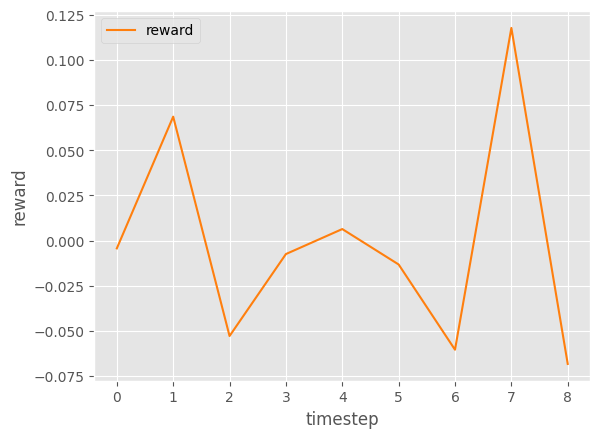

In [77]:
# let's visualize the transition of reward
obs, info = env.reset()
done = False
reward_list = []

while not done:
    action = agent.sample_action_online(obs)

    obs, reward, done, truncated, info = env.step(action)
    reward_list.append(reward)

# plot
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.plot(reward_list[:-1], label='reward', color='tab:orange')
ax1.set_xlabel('timestep')
ax1.set_ylabel('reward')
ax1.legend(loc='upper left')
plt.show()

For more about the environmental configurations and customization, please refer to [examples/quickstart/rec_synthetic_customize_env.ipynb](https://github.com/negocia-inc/rec_reinforcement_learing/blob/ope/examples/quickstart/rec_synthetic_customize_env.ipynb).

#### Online RL and comparison of the policies
We now learn an online RL policy and compare it to the random policy, using on-policy policy estimation.

In [78]:
# standardized environment for discrete action
env = RECEnv(random_state=random_state)

In [79]:
# for api compatibility to d3rlpy
from ofrl.utils import OldGymAPIWrapper
env_ = OldGymAPIWrapper(env)

In [80]:
from d3rlpy.algos import DoubleDQN
from d3rlpy.models.encoders import VectorEncoderFactory
from d3rlpy.models.q_functions import MeanQFunctionFactory
from d3rlpy.online.buffers import ReplayBuffer
from d3rlpy.online.explorers import LinearDecayEpsilonGreedy

# model
ddqn = DoubleDQN(
    encoder_factory=VectorEncoderFactory(hidden_units=[30, 30]),
    q_func_factory=MeanQFunctionFactory(),
    target_update_interval=100,
    use_gpu=torch.cuda.is_available(),
)
# replay buffer
buffer = ReplayBuffer(
    maxlen=10000,
    env=env_,
)
# explorers
explorer = LinearDecayEpsilonGreedy(
    start_epsilon=1.0,
    end_epsilon=0.3,
    duration=1000,
)

In [81]:
# start training
# skip if there is a pre-trained model
ddqn.fit_online(
    env_,
    buffer,
    explorer=explorer,
    eval_env=env_,
    n_steps=100000,
    n_steps_per_epoch=1000,
    update_start_step=1000,
)

2023-01-29 21:22.40 [info     ] Directory is created at d3rlpy_logs/DoubleDQN_online_20230129212240
2023-01-29 21:22.40 [debug    ] Building model...
2023-01-29 21:22.40 [debug    ] Model has been built.
2023-01-29 21:22.40 [info     ] Parameters are saved to d3rlpy_logs/DoubleDQN_online_20230129212240/params.json params={'action_scaler': None, 'batch_size': 32, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.99, 'generated_maxlen': 100000, 'learning_rate': 6.25e-05, 'n_critics': 1, 'n_frames': 1, 'n_steps': 1, 'optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'real_ratio': 1.0, 'reward_scaler': None, 'scaler': None, 'target_update_interval': 100, 'use_gpu': None, 'algorithm': 'DoubleDQN', 'observation_shape': (5,), 'action_s

  0%|          | 0/100000 [00:00<?, ?it/s]

2023-01-29 21:22.41 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20230129212240/model_1000.pt
2023-01-29 21:22.41 [info     ] DoubleDQN_online_20230129212240: epoch=1 step=1000 epoch=1 metrics={'time_inference': 0.00011498355865478516, 'time_environment_step': 1.6955137252807616e-05, 'time_step': 0.00013952016830444337, 'rollout_return': -0.20960499667670404, 'evaluation': -0.6367018346739413} step=1000
2023-01-29 21:22.41 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20230129212240/model_2000.pt
2023-01-29 21:22.41 [info     ] DoubleDQN_online_20230129212240: epoch=2 step=2000 epoch=2 metrics={'time_inference': 0.00012026786804199219, 'time_environment_step': 2.0923614501953126e-05, 'time_sample_batch': 2.3125648498535155e-05, 'time_algorithm_update': 0.0005852217674255371, 'loss': 0.017590796302072702, 'time_step': 0.0007635457515716553, 'rollout_return': 0.14012319116026692, 'evaluation': 0.1528253118222944} step=2000
2023-01-29 21:

In [82]:
# save model
ddqn.save_model("d3rlpy_logs/ddqn.pt")

In [83]:
# reload model
ddqn.build_with_env(env_)
ddqn.load_model("d3rlpy_logs/ddqn.pt")

2023-01-29 21:23.58 [warning  ] Parameters will be reinitialized.


Text(0, 0.5, 'episode reward')

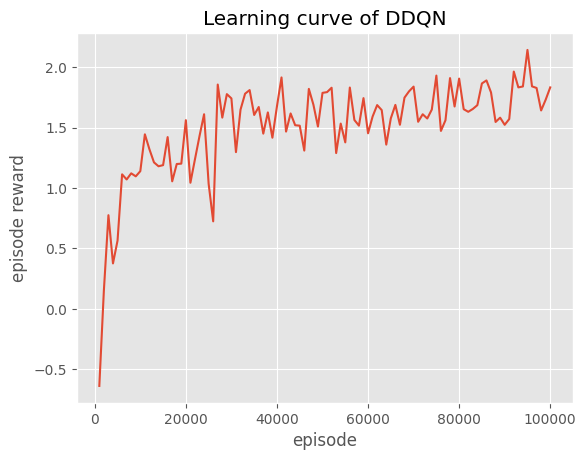

In [84]:
# we see that training RL policy can be risky online
log_path = sorted(glob("d3rlpy_logs/DoubleDQN_online_*/evaluation.csv"))[-1]
df = pd.read_csv(
    log_path, 
    usecols=[1,2],
    names=["train_episode", "episodic_rewards"]
)
plt.plot(df["train_episode"], df["episodic_rewards"])
plt.title("Learning curve of DDQN")
plt.xlabel("episode")
plt.ylabel("episode reward")

In [85]:
random = DiscreteRandomPolicy()
random.build_with_env(env_)

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

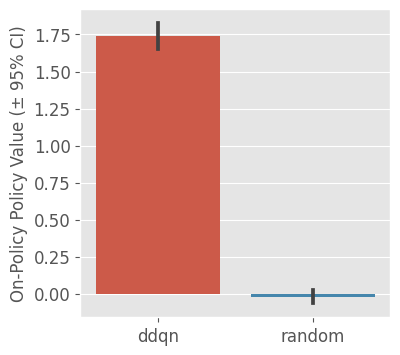

In [86]:
# compare the policy performance online
visualize_on_policy_policy_value(
    env=env,
    policies=[ddqn, random],
    policy_names=["ddqn", "random"],
    n_trajectories=100,
    random_state=random_state,
)

In [87]:
# on-policy policy value by ddqn policy
# largely outperforms the random policy (about 20%)
ddqn_performance = calc_on_policy_policy_value(env, ddqn, n_trajectories=100, random_state=random_state)
random_performance = calc_on_policy_policy_value(env, random, n_trajectories=100, random_state=random_state)
print("relative improvement:", (ddqn_performance - random_performance) / random_performance)

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

relative improvement: -44.11640640480552


Note that, we provide the following functions for online evaluation of the policy performance under `ofrl.ope.online`.

(Statistics)

* `calc_on_policy_policy_value`
* `calc_on_policy_policy_value_interval`
* `calc_on_policy_variance`
* `calc_on_policy_conditional_value_at_risk`
* `calc_on_policy_policy_interquartile_range`
* `calc_on_policy_cumulative_distribution_function`

(Visualization)
* `visualize_on_policy_policy_value`
* `visualize_on_policy_policy_value_with_variance`
* `visualize_on_policy_cumulative_distribution_function`
* `visualize_on_policy_conditional_value_at_risk`
* `visualize_on_policy_interquartile_range`

## 1. Synthetic Dataset Generation
In the previous section, we see how we can interact with the environment *online* using synthetic simulator.  
Though simulation is a good starting point for training an agent, eventually we want to deploy our agent (or policy) in the real world environment.  
However, online interaction may have potential risk of failure in the real-world.
Therefore, we introduce an alternative learning protocol, Offline RL, which aims at training a new policy using only offline logged dataset collected by a behavior policy $\pi_0$:

$$\mathcal{D}_0 := \{ \{ s_t, a_t, s_{t+1}, r_t \}_{t=1}^T \}_{i=1}^n \sim \prod_{i=1}^n d_{s_0}(s_0) \prod_{t=1}^T \pi_0(a_t | s_t) p(s_{t+1} | s_t, a_t) p(r_t | s_t, a_t),$$

where $s_t \in \mathcal{S}$ is the state observed at timestep $t$, $a_t$ is the action chosen by the behavior policy $\pi_0$, and $r_t$ is the reward. 

We prepare an easy-to-use synthetic dataset generator: `SyntheticDataset` class in the dataset module.  
By regarding the simulation environment as a hypothetical real-environment, we show how to conduct Offline RL using logged dataset in real-world application.  
For detailed description of how to use a real-world dataset, please see #TODO (will be implemented).

`SyntheticDataset` has the following arguments:
- `env`: Recommender environment for RL defined in the previous section.
- `max_episode_steps`: Maximum number of timesteps in an episode.

In [88]:
# import necessary module from OFRL
from ofrl.policy import DiscreteEpsilonGreedyHead

In [89]:
behavior_policy = DiscreteEpsilonGreedyHead(
    ddqn, 
    n_actions=env.action_space.n,
    epsilon=0.3,
    name="ddqn_epsilon_0.3",
    random_state=random_state,
)

In [90]:
# initialize dataset class
dataset = SyntheticDataset(
    env=env,
    max_episode_steps=env.step_per_episode,
)

In [91]:
# collect logged data by a behavior policy
# skip if there is a preserved logged dataset
train_logged_dataset = dataset.obtain_episodes(
    behavior_policies=behavior_policy,
    n_trajectories=10000, 
    obtain_info=False,
    random_state=random_state,
)
test_logged_dataset = dataset.obtain_episodes(
    behavior_policies=behavior_policy,
    n_trajectories=10000, 
    obtain_info=False,
    random_state=random_state + 1,
)

[obtain_trajectories]:   0%|          | 0/10000 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/10000 [00:00<?, ?it/s]

In [92]:
train_logged_dataset

{'size': 100000,
 'n_trajectories': 10000,
 'step_per_trajectory': 10,
 'action_type': 'discrete',
 'n_actions': 100,
 'action_dim': None,
 'action_meaning': None,
 'action_keys': None,
 'state_dim': 5,
 'state_keys': None,
 'state': array([[ 0.04479014,  0.11492637, -0.05131316, -0.0280654 ,  0.0347718 ],
        [ 0.31921636,  0.81394389, -0.36851645, -0.1963369 ,  0.24747467],
        [ 0.32179456,  0.814192  , -0.36174882, -0.19742055,  0.25239366],
        ...,
        [-0.02714754, -0.2751157 ,  0.76551473, -0.39444382, -0.42658603],
        [-0.00305992, -0.28838619,  0.76296553, -0.37898356, -0.43712596],
        [ 0.02112386, -0.30138496,  0.75955249, -0.36303955, -0.44721717]]),
 'action': array([48,  1, 39, ..., 13, 13, 13]),
 'reward': array([ 0.0049548 , -0.06859422,  0.12817249, ...,  0.17424734,
         0.18073319,  0.1870417 ]),
 'done': array([0., 0., 0., ..., 0., 0., 1.]),
 'terminal': array([0., 0., 0., ..., 0., 0., 1.]),
 'info': {},
 'pscore': array([0.703, 0.003,

In [93]:
with open("logs/train_dataset_discrete_ddqn.pkl", "wb") as f:
    pickle.dump(train_logged_dataset, f)
with open("logs/test_dataset_discrete_ddqn.pkl", "wb") as f:
    pickle.dump(test_logged_dataset, f)

In [94]:
with open("logs/train_dataset_discrete_ddqn.pkl", "rb") as f:
    train_logged_dataset = pickle.load(f)
with open("logs/test_dataset_discrete_ddqn.pkl", "rb") as f:
    test_logged_dataset = pickle.load(f)

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

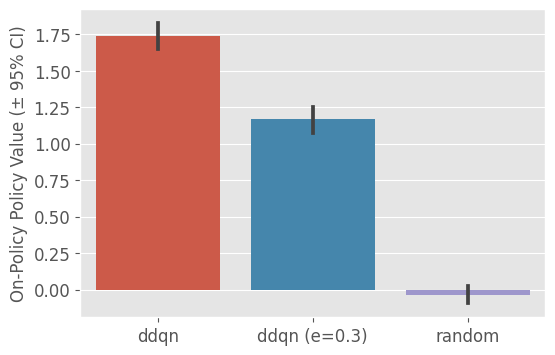

In [95]:
# compare the policy performance online
# almost the same performance as greedy ddqn
visualize_on_policy_policy_value(
    env=env,
    policies=[ddqn, behavior_policy, random],
    policy_names=["ddqn", "ddqn (e=0.3)", "random"],
    n_trajectories=100,
    random_state=random_state,
)

For more about the data collection and visualization, please refer to [examples/quickstart/rec_synthetic_data_collection.ipynb](https://github.com/negocia-inc/rec_reinforcement_learing/blob/ope/examples/quickstart/rec_synthetic_data_collection.ipynb).

## 2. Offline Reinforcement Learning
In this section, we learn a new policy in an offline manner, without interacting with the environment.  
We use [d3rlpy](https://github.com/takuseno/d3rlpy)'s implementation of algorithms.

In [96]:
# import modules from d3rlpy
from d3rlpy.dataset import MDPDataset
from d3rlpy.algos import DiscreteCQL
from d3rlpy.ope import DiscreteFQE
from d3rlpy.metrics.scorer import evaluate_on_environment

In [97]:
offlinerl_dataset = MDPDataset(
    observations=train_logged_dataset["state"],
    actions=train_logged_dataset["action"],
    rewards=train_logged_dataset["reward"],
    terminals=train_logged_dataset["done"],
    episode_terminals=train_logged_dataset["done"],
    discrete_action=True,
)
train_episodes, test_episodes = train_test_split(offlinerl_dataset, test_size=0.2, random_state=random_state)

In [98]:
# Use Conservative Q-Learning policy
cql = DiscreteCQL(
    encoder_factory=VectorEncoderFactory(hidden_units=[30, 30]),
    q_func_factory=MeanQFunctionFactory(),
    use_gpu=torch.cuda.is_available(),
)

In [99]:
cql.fit(
    train_episodes,
    eval_episodes=test_episodes,
    n_steps=10000,
    scorers={
        'environment': evaluate_on_environment(env_),
        # to record training process w/ ground truth policy value, which is unseen to the agent
    },
)

2023-01-29 21:24.44 [debug    ] RandomIterator is selected.
2023-01-29 21:24.44 [info     ] Directory is created at d3rlpy_logs/DiscreteCQL_20230129212444
2023-01-29 21:24.44 [debug    ] Building models...
2023-01-29 21:24.44 [debug    ] Models have been built.
2023-01-29 21:24.44 [info     ] Parameters are saved to d3rlpy_logs/DiscreteCQL_20230129212444/params.json params={'action_scaler': None, 'alpha': 1.0, 'batch_size': 32, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.99, 'generated_maxlen': 100000, 'learning_rate': 6.25e-05, 'n_critics': 1, 'n_frames': 1, 'n_steps': 1, 'optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'real_ratio': 1.0, 'reward_scaler': None, 'scaler': None, 'target_update_interval': 8000, 'use_gpu': 

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-01-29 21:24.54 [info     ] DiscreteCQL_20230129212444: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 6.662161350250245e-05, 'time_algorithm_update': 0.0009048242568969727, 'loss': 3.9870537371397017, 'time_step': 0.0010204562425613403, 'environment': 1.7355069039978595} step=10000
2023-01-29 21:24.54 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20230129212444/model_10000.pt


[(1,
  {'time_sample_batch': 6.662161350250245e-05,
   'time_algorithm_update': 0.0009048242568969727,
   'loss': 3.9870537371397017,
   'time_step': 0.0010204562425613403,
   'environment': 1.7355069039978595})]

In [100]:
# save model
cql.save_model("d3rlpy_logs/cql_discrete.pt")

In [101]:
# reload model
cql.build_with_env(env_)
cql.load_model("d3rlpy_logs/cql_discrete.pt")

2023-01-29 21:24.54 [warning  ] Parameters will be reinitialized.


[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

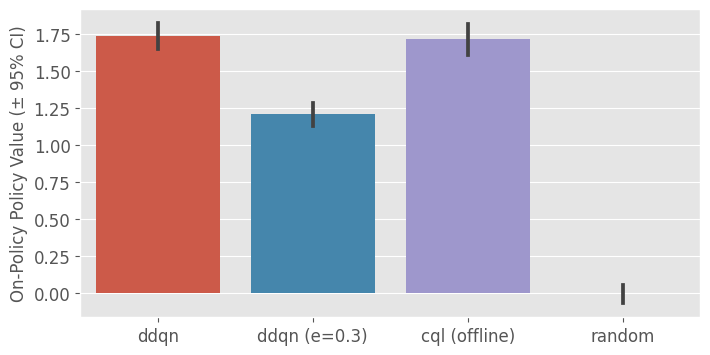

In [102]:
# compare the policy performance online
# not better than online policy, but achieves almost the same performance
# meaning that we can learn a reasonable policy without interacting with the environment!
visualize_on_policy_policy_value(
    env=env,
    policies=[ddqn, behavior_policy, cql, random],
    policy_names=["ddqn", "ddqn (e=0.3)", "cql (offline)", "random"],
    n_trajectories=100,
    random_state=random_state,
)

## 3. Off-Policy Evaluation and Evaluation of Offline RL methods
In the previous section, we verified the performance of a learned policy via online interaction (aka A/B tests).  
However, it could be risky because the policy may perform poorly in an online environment.  
To tackle this issue, we aim at evaluating the performance of a policy offline, to gain some prior knowledge on how agent works in the environment.

#### Estimation Target

The goal to estimate the estimators' average policy performance, the *policy value*.

$$ V(\pi) := \mathbb{E}\left[\sum_{t=1}^T \gamma^{t-1} r_t \mid \pi \right] $$

In [103]:
# import ope modules from OFRL
from ofrl.ope import CreateOPEInput
from ofrl.ope import OffPolicyEvaluation as OPE
from ofrl.ope import DiscreteDirectMethod as DM
from ofrl.ope import DiscreteTrajectoryWiseImportanceSampling as TIS
from ofrl.ope import DiscretePerDecisionImportanceSampling as PDIS
from ofrl.ope import DiscreteDoublyRobust as DR
from ofrl.ope import DiscreteSelfNormalizedTrajectoryWiseImportanceSampling as SNTIS
from ofrl.ope import DiscreteSelfNormalizedPerDecisionImportanceSampling as SNPDIS
from ofrl.ope import DiscreteSelfNormalizedDoublyRobust as SNDR

In [104]:
# define evaluation policies
cql_ = DiscreteEpsilonGreedyHead(base_policy=cql, n_actions=env.action_space.n, name="cql", epsilon=0.0, random_state=random_state)
ddqn_ = DiscreteEpsilonGreedyHead(base_policy=ddqn, n_actions=env.action_space.n, name="ddqn", epsilon=0.0, random_state=random_state)
random_ = DiscreteEpsilonGreedyHead(base_policy=random, n_actions=env.action_space.n, name="random", epsilon=1.0, random_state=random_state)
evaluation_policies = [cql_, ddqn_, random_]

In [105]:
# first, prepare OPE inputs
prep = CreateOPEInput(
    env=env,
    model_args={
        "fqe": {
            "encoder_factory": VectorEncoderFactory(hidden_units=[30, 30]),
            "q_func_factory": MeanQFunctionFactory(),
            "learning_rate": 1e-4,
            "use_gpu": torch.cuda.is_available(),
        }
    },
    state_scaler=MinMaxScaler(
        minimum=test_logged_dataset["state"].min(axis=0),
        maximum=test_logged_dataset["state"].max(axis=0),
    ),
)

In [106]:
# takes time
input_dict = prep.obtain_whole_inputs(
    logged_dataset=test_logged_dataset,
    evaluation_policies=evaluation_policies,
    require_value_prediction=True,
    n_trajectories_on_policy_evaluation=100,
    random_state=random_state,
)

[fit FQE model]:   0%|          | 0/3 [00:00<?, ?it/s]

2023-01-29 21:24.55 [debug    ] RoundIterator is selected.
2023-01-29 21:24.55 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230129212455
2023-01-29 21:24.55 [debug    ] Fitting scaler...              scaler=min_max
2023-01-29 21:24.55 [debug    ] Building models...
2023-01-29 21:24.55 [debug    ] Models have been built.
2023-01-29 21:24.55 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230129212455/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 1.0, 'generated_maxlen': 100000, 'learning_rate': 0.0001, 'n_critics': 1, 'n_frames': 1, 'n_steps': 1, 'optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'real_ratio': 1.0, 'reward_scaler': None

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-01-29 21:24.56 [info     ] DiscreteFQE_20230129212455: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 7.772278785705566e-05, 'time_algorithm_update': 0.0007570114135742187, 'loss': 0.03518086710013449, 'time_step': 0.0008648686408996582} step=1000
2023-01-29 21:24.56 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230129212455/model_1000.pt
2023-01-29 21:24.56 [debug    ] RoundIterator is selected.
2023-01-29 21:24.56 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230129212456
2023-01-29 21:24.56 [debug    ] Fitting scaler...              scaler=min_max
2023-01-29 21:24.56 [debug    ] Building models...
2023-01-29 21:24.56 [debug    ] Models have been built.
2023-01-29 21:24.56 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230129212456/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'drop

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-01-29 21:24.57 [info     ] DiscreteFQE_20230129212456: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 7.482361793518067e-05, 'time_algorithm_update': 0.0007432696819305419, 'loss': 0.03405065023712814, 'time_step': 0.0008460488319396972} step=1000
2023-01-29 21:24.57 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230129212456/model_1000.pt
2023-01-29 21:24.57 [debug    ] RoundIterator is selected.
2023-01-29 21:24.57 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230129212457
2023-01-29 21:24.57 [debug    ] Fitting scaler...              scaler=min_max
2023-01-29 21:24.57 [debug    ] Building models...
2023-01-29 21:24.57 [debug    ] Models have been built.
2023-01-29 21:24.57 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230129212457/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'drop

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-01-29 21:24.58 [info     ] DiscreteFQE_20230129212457: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 7.482719421386719e-05, 'time_algorithm_update': 0.00061114501953125, 'loss': 0.014127508444245904, 'time_step': 0.000715458869934082} step=1000
2023-01-29 21:24.58 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230129212457/model_1000.pt


[collect input data: eval_policy]:   0%|          | 0/3 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

In [107]:
with open("logs/ope_input_dict_discrete.pkl", "wb") as f:
    pickle.dump(input_dict, f)

In [108]:
with open("logs/ope_input_dict_discrete.pkl", "rb") as f:
    input_dict = pickle.load(f)

In [109]:
ope = OPE(
    logged_dataset=test_logged_dataset,
    ope_estimators=[DM(), TIS(), PDIS(), DR(), SNTIS(), SNPDIS(), SNDR()],
)

In [110]:
# performance estimation by ope
policy_value_df_dict, policy_value_interval_df_dict = ope.summarize_off_policy_estimates(input_dict, random_state=random_state)

In [111]:
# estimated policy performance
policy_value_df_dict

{'cql':            policy_value  relative_policy_value
 on_policy      1.717192               1.000000
 dm             0.889752               0.518144
 tis            0.665044               0.387286
 pdis           1.869613               1.088762
 dr             2.485699               1.447537
 sntis          1.766366               1.028636
 snpdis         1.799961               1.048200
 sndr           1.813980               1.056364,
 'ddqn':            policy_value  relative_policy_value
 on_policy      1.741982               1.000000
 dm             0.762965               0.437987
 tis            1.494926               0.858176
 pdis           1.683341               0.966337
 dr             1.806590               1.037089
 sntis          1.748930               1.003989
 snpdis         1.736111               0.996630
 sndr           1.724717               0.990089,
 'random':            policy_value  relative_policy_value
 on_policy     -0.022150                    NaN
 dm          

In [112]:
# estimated confidence intervals of the policy performance
policy_value_interval_df_dict

{'cql':                mean  95.0% CI (lower)  95.0% CI (upper)
 on_policy  1.713429          1.624464          1.811324
 dm         0.889756          0.889426          0.890105
 tis        0.654290          0.537320          0.775058
 pdis       1.803321          0.929567          2.888922
 dr         2.424956          1.562687          3.590236
 sntis      1.737804          1.427128          2.058566
 snpdis     1.740151          1.007053          2.680832
 sndr       1.768938          1.032936          2.846921,
 'ddqn':                mean  95.0% CI (lower)  95.0% CI (upper)
 on_policy  1.737656          1.659017          1.803973
 dm         0.762761          0.761227          0.764141
 tis        1.484529          1.320984          1.684194
 pdis       1.682160          1.606746          1.761252
 dr         1.810777          1.757209          1.862705
 sntis      1.736767          1.545433          1.970357
 snpdis     1.734738          1.653743          1.817801
 sndr       1.7

## 4. Evaluation of OPE methods
Now, we evaluate how well the ope estimators estimated the policy value.

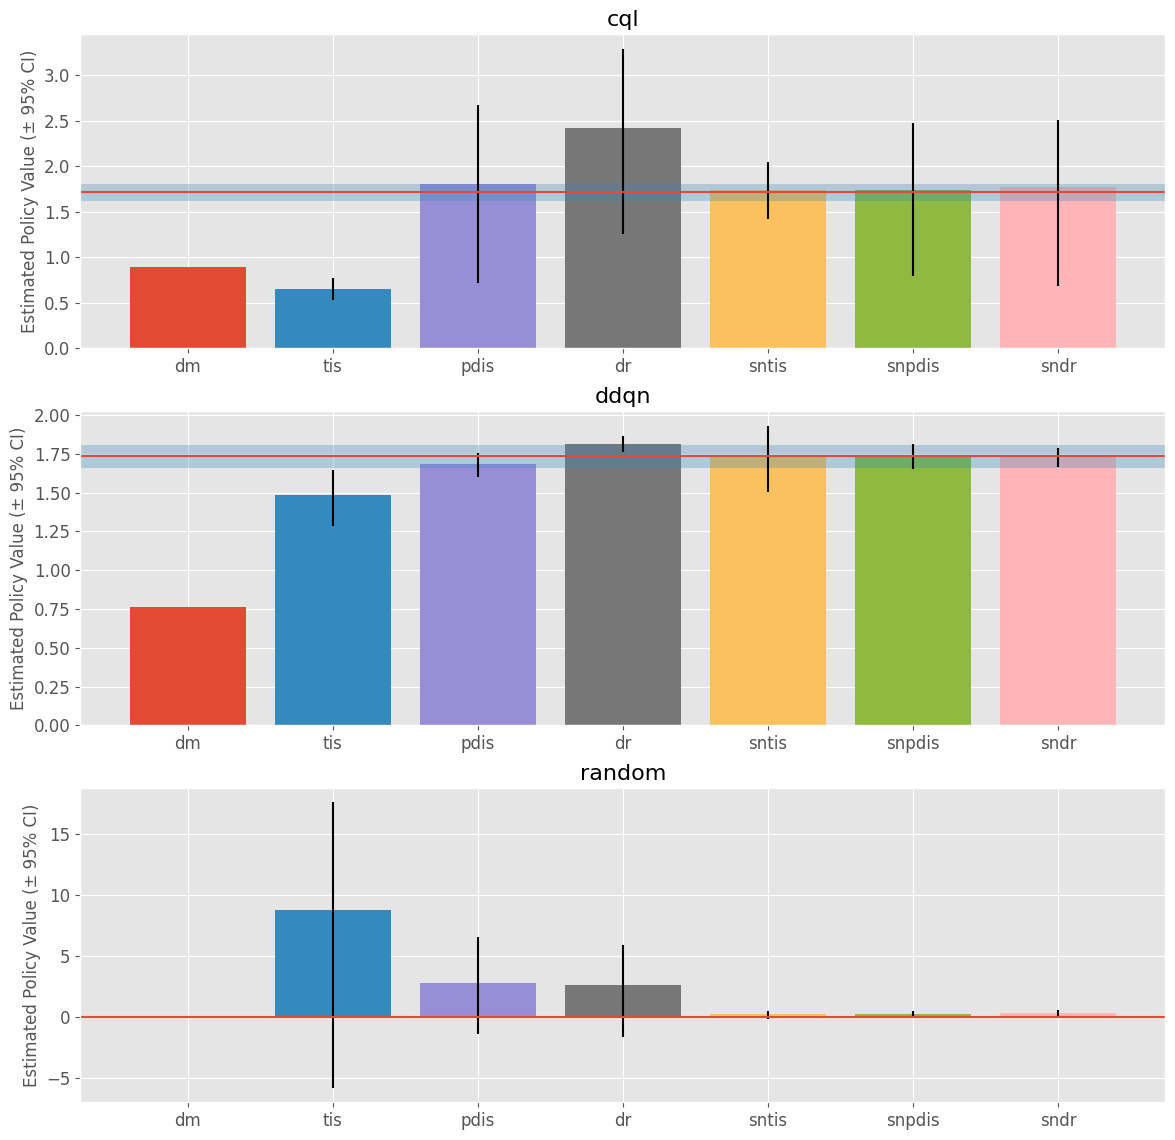

In [113]:
# we can visualize and compare the result
# it seems that DM tends to have a bias though the variance is quite small, 
# while (trajectory-wise) importance sampling estimators have a smaller bias with a larger variance.
# self-normalized estimators also works well
ope.visualize_off_policy_estimates(input_dict, random_state=random_state, sharey=False)

In [114]:
# squared-error (se) measures the estimation accuracy of OPE
eval_metric_ope_df = ope.evaluate_performance_of_ope_estimators(
    input_dict, 
    metric="se",
    return_by_dataframe=True,
)
eval_metric_ope_df

,cql,ddqn,random
dm,0.684657,0.958473,0.006240
tis,1.107015,0.061036,83.303573
pdis,0.023232,0.003439,7.224014
dr,0.590603,0.004174,5.847921
sntis,0.002418,0.000048,0.083979
snpdis,0.006851,0.000034,0.076492
sndr,0.009368,0.000298,0.100767


For more advanced topics in OPE (e.g., cumulative distribution function estimation) and OPS, please refer to [examples/quickstart/rec_synthetic_discrete_advanced.ipynb](https://github.com/negocia-inc/rec_reinforcement_learing/blob/ope/examples/quickstart/rec_synthetic_discrete_advanced.ipynb). 

For more advanced OPE estimators (e.g., state(-action) marginal estimators and double reinforcement learning), please refer to [examples/quickstart/rec_synthetic_discrete_zoo.ipynb](https://github.com/negocia-inc/rec_reinforcement_learing/blob/ope/examples/quickstart/rec_synthetic_discrete_zoo.ipynb). 

## Reference

- Yuta Saito, Shunsuke Aihara, Megumi Matsutani, and Yusuke Narita. \
"Open Bandit Dataset and Pipeline: Towards Realistic and Reproducible Off-Policy Evaluation.", 2021.

- Takuma Seno and Michita Imai. \
"d3rlpy: An Offline Deep Reinforcement Library.", 2021.

- Sergey Levine, Aviral Kumar, George Tucker, and Justin Fu. \
"Offline Reinforcement Learning: Tutorial, Review, and Perspectives on Open Problems." 2020.

- Aviral Kumar, Aurick Zhou, George Tucker, and Sergey Levine. \
"Conservative Q-Learning for Offline Reinforcement Learning.", 2020.

- Nathan Kallus and Masatoshi Uehara. \
"Intrinsically Efficient, Stable, and Bounded Off-Policy Evaluation for Reinforcement Learning.", 2019.

- Hoang Le, Cameron Voloshin, and Yisong Yue. \
"Batch Policy Learning under Constraints.", 2019.

- Di Wu, Xiujun Chen, Xun Yang, Hao Wang, Qing Tan, Xiaoxun Zhang, Jian Xu, and Kun Gai. \
"Budget Constrained Bidding by Model-free Reinforcement Learning in Display Advertising.", 2018.

- Jun Zhao, Guang Qiu, Ziyu Guan, Wei Zhao, and Xiaofei He. \
"Deep Reinforcement Learning for Sponsored Search Real-time Bidding.", 2018.

- Nan Jiang and Lihong Li. \
"Doubly Robust Off-policy Value Evaluation for Reinforcement Learning.", 2016.

- Philip S. Thomas and Emma Brunskill. \
"Data-Efficient Off-Policy Policy Evaluation for Reinforcement Learning.", 2016.

- Greg Brockman, Vicki Cheung, Ludwig Pettersson, Jonas Schneider, John Schulman, Jie Tang, and Wojciech Zaremba. \
"OpenAI Gym.", 2016.

- Adith Swaminathan and Thorsten Joachims. \
"The Self-Normalized Estimator for Counterfactual Learning.", 2015.

- Hado van Hasselt, Arthur Guez, and David Silver. \
"Deep Reinforcement Learning with Double Q-learning.", 2015.

- Miroslav Dudík, Dumitru Erhan, John Langford, and Lihong Li. \
"Doubly Robust Policy Evaluation and Optimization.", 2014.

- Alex Strehl, John Langford, Sham Kakade, and Lihong Li. \
"Learning from Logged Implicit Exploration Data.", 2010.

- Alina Beygelzimer and John Langford. \
"The Offset Tree for Learning with Partial Labels.", 2009.

- Doina Precup, Richard S. Sutton, and Satinder P. Singh. \
"Eligibility Traces for Off-Policy Policy Evaluation.", 2000.